In [58]:
import clean_data
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter

In [2]:
df = clean_data.create_df_from_mongo()

import data from mongoDB to pandas dataframe


In [60]:
cleaned_df = clean_data.add_features(df)

In [70]:
user_lifetimes(cleaned_df)

[(169367, 0, True),
 (10667987, 1, False),
 (0, 2, True),
 (370884, 3, True),
 (253251, 4, True),
 (9213777, 5, False),
 (10793185, 6, False),
 (5602804, 7, False),
 (591835, 8, True),
 (1220635, 9, True),
 (11542, 10, True),
 (4396512, 11, True),
 (179436, 12, True),
 (5615278, 13, True),
 (43798, 14, True),
 (5160199, 15, True),
 (2866145, 16, True),
 (8993508, 17, False),
 (2837993, 18, True),
 (6253329, 19, True),
 (532012, 20, True),
 (8190986, 21, False),
 (9846865, 22, False),
 (4886874, 23, False),
 (4303908, 24, True),
 (445300, 25, True),
 (10115109, 26, False),
 (11101480, 27, False),
 (3046423, 28, True),
 (0, 29, False),
 (0, 30, True),
 (717083, 31, True),
 (2202, 32, True),
 (7734365, 33, True),
 (243748, 34, True),
 (1353272, 35, True),
 (2667661, 36, True),
 (1588082, 37, True),
 (1819761, 38, True),
 (9238807, 39, False),
 (10438999, 40, False),
 (11312982, 41, False),
 (124647, 42, True),
 (739655, 43, True),
 (11120772, 44, False),
 (0, 45, True),
 (2299, 46, True),

In [71]:
for duration_, player, death_observed in user_lifetimes(df):
        cleaned_df.loc[player, 'duration_days'] = duration_ / 86400 
        cleaned_df.loc[player, 'death_observed'] = death_observed

In [73]:
cleaned_df.columns

Index(['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz', 'chess_bullet',
       'chess_daily', 'chess_rapid', 'country', 'followers', 'games', 'joined',
       'last_online', 'location', 'name', 'player_id', 'status', 'url',
       'username', 'duration_days', 'death_observed', 'fourth_month_games',
       'first_month_games', 'highest_rating', 'lowest_rating', 'rated',
       'chess', 'checkmated', 'resigned', 'timeout', 'win', 'abandoned',
       'timevsinsufficient', 'stalemate', 'insufficient', 'unrated',
       'repetition', 'agreed', 'bughouse', 'crazyhouse', 'kingofthehill',
       'chess960', 'threecheck', 'bughousepartnerlose', '50move', 'inactive',
       'has_name', 'has_location', 'has_avatar', 'is_basic', 'is_premium'],
      dtype='object')

In [56]:
max_value = 1526169600 - 1514764800

The purpose of this notebook is to use the Lifelines module to do some user segmentation on the chess.com dataset

Things I need to do:
1. Get the first and last games played by each player (determine duration of users time on site)
2. what period of time of inactivity will I consider death (2 weeks without a game?)
3. make some graphs
4. segment population


loop through all games by an individual
    if the diff in time between the next game or current time is greater than two weeks:
        take the last time as the 'death' event
'birth' event = sign up date (maybe first game?)
duration of user 'life' = death time - birth time

In [3]:
def game_end_time(df, player, month, game):
    '''returns type of time control if the game was played within the first 30 days'''
    return df['games'][player][month][0]['games'][game]['end_time']

def user_lifetimes(df):
    end_time = 1526169600
    player_idxes = range(df.shape[0])
    all_times = []
    for player in player_idxes:
        time_of_games = []
        for month in range(5):
            try:
                for game in range(clean_data.games_in_a_month(df, player, month)):
                    time_of_games.append(game_end_time(df, player, month, game))
            except (KeyError, IndexError):
                continue
        if time_of_games:
            birth = time_of_games[0]
            death = duration(time_of_games)
            if not death:
                still_alive = time_of_games[-1] - birth
                all_times.append((still_alive, player, False))
            else:
                all_times.append(((death - birth), player, True))
        else:
            all_times.append((0, player, True))
    return all_times

def duration(time_of_games):
    time_of_inactivity = 604800
    for i, x in enumerate(time_of_games):
        if x - time_of_games[i - 1] > time_of_inactivity:
            return time_of_games[i - 1]

In [4]:
user_times = user_lifetimes(df)

In [36]:
def fake_death_time(time_of_games):
    seconds_in_two_weeks = 50
    times = duration(time_of_games)
    if times:
        return times[0]
    else:
        return time_of_games[-1] - time_of_games[0]
        
nums = [[2, 5, 10, 16, 24], [0, 2, 7, 8, 15, 100], [23, 25, 100, 102, 103], [], [1, 10000, 200000], [1516154262, 1516318955, 1516320601, 1516320864, 1516321154, 1516321416, 1516322103, 1516322534, 1516322614, 1516323629, 1522709922, 1522722105, 1522794278, 1522886378, 1523065535, 1523066047, 1523143799, 1523144383, 1523207447, 1523727492, 1523728070, 1523821548, 1523821610, 1523821718, 1523822394, 1524323057, 1524323888, 1524324698, 1524341290, 1524342351, 1524343346, 1524959707, 1524960033, 1525819501, 1525820389]]
for num in nums:
    if num:
#         print(death_time(num))
        print(duration(num))
    else:
        print(0)

None
15
25
0
1
1516154262


In [64]:
def add_lifetimes(df):   
    for duration_, player, death_observed in user_lifetimes(df):
        df.loc[player, 'duration_days'] = duration_ / 86400 
        df.loc[player, 'death_observed'] = death_observed

In [42]:
df['status'].value_counts()

basic      1303
premium     150
Name: status, dtype: int64

In [26]:
df[['player_id', 'duration_days', 'death_observed']]

,player_id,duration_days,death_observed
0,42361082,1.960266,True
1,42121838,123.472072,False
2,42324950,0.000000,True
3,42192576,4.292639,True
4,42332948,2.931146,True
5,42762076,106.640938,False
6,42165872,124.921123,False
7,42530248,64.847269,False
8,42824544,6.849942,True
9,42425796,14.127720,True


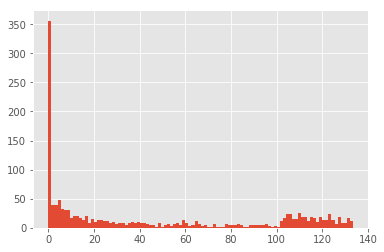

In [27]:
df['duration_days'].hist(bins=100)

In [44]:
df_no_zero_time = df[df['duration_days'] != 0]
premium = df_no_zero_time['status'] == 'premium'
basic = df_no_zero_time['status'] != 'premium'

T = df_no_zero_time['duration_days']
E = df_no_zero_time['death_observed']

In [28]:
kmf = KaplanMeierFitter()

T = df[df['duration_days'] != 0]['duration_days']
E = df[df['duration_days'] != 0]['death_observed']

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 1210 observations, 427 censored>

Text(0.5,1,'Survival Function of Chess.com Users')

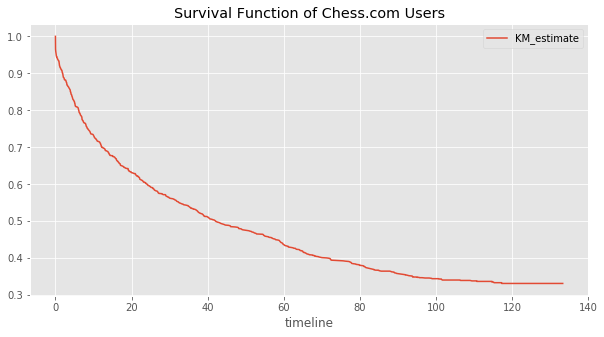

In [31]:
kmf.survival_function_.plot(figsize=(10, 5))
plt.title('Survival Function of Chess.com Users')

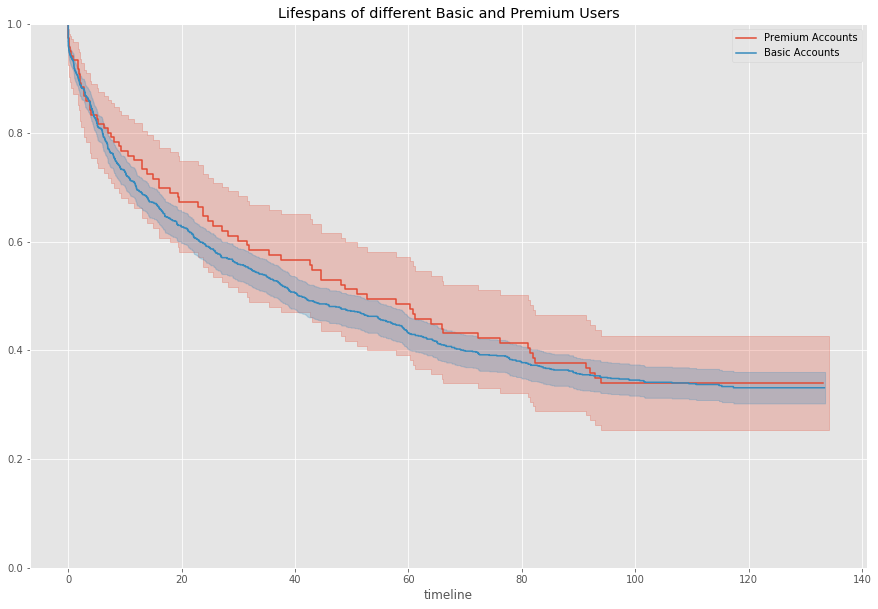

In [51]:
fig, ax = plt.subplots(figsize=(15, 10))

kmf.fit(T[premium], event_observed=E[premium], label="Premium Accounts")
kmf.plot(ax=ax)
kmf.fit(T[basic], event_observed=E[basic], label="Basic Accounts")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Lifespans of different Basic and Premium Users");

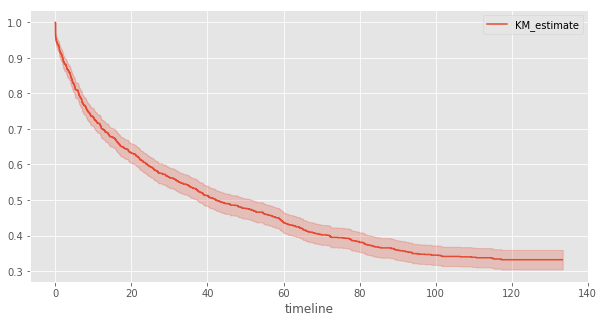

In [32]:
kmf.plot(figsize=(10, 5));

In [36]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter: fitted with 1210 observations, 427 censored>

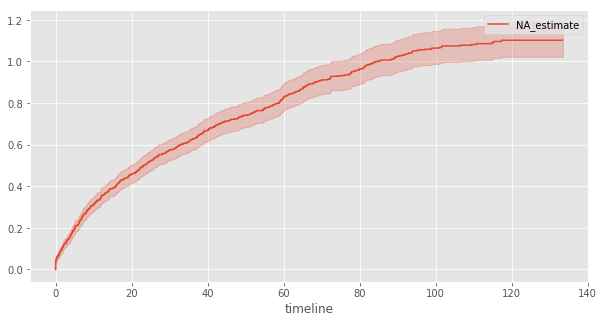

In [39]:
naf.plot(figsize=(10, 5))

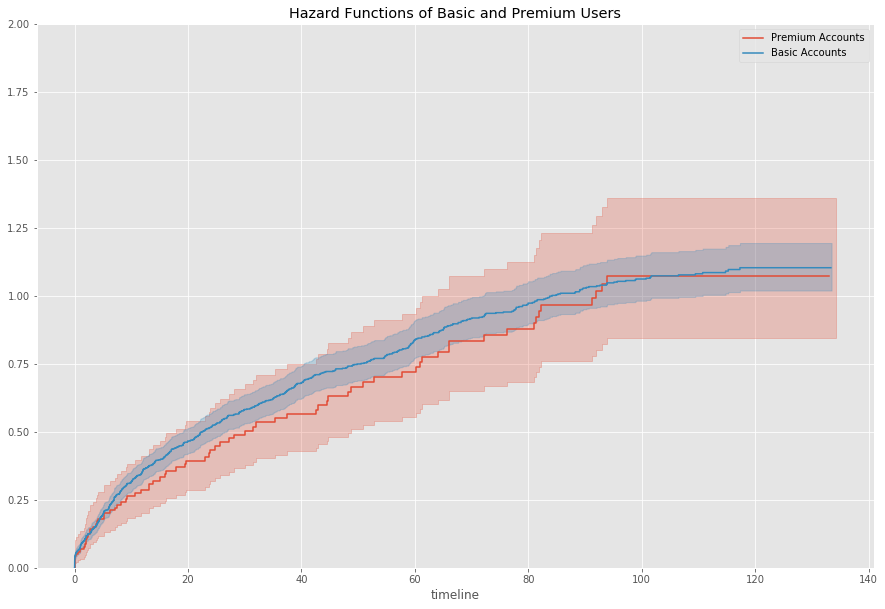

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))

naf.fit(T[premium], event_observed=E[premium], label="Premium Accounts")
naf.plot(ax=ax)
naf.fit(T[basic], event_observed=E[basic], label="Basic Accounts")
naf.plot(ax=ax)

plt.ylim(0, 2);
plt.title("Hazard Functions of Basic and Premium Users");

In [74]:
cleaned_df.columns

Index(['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz', 'chess_bullet',
       'chess_daily', 'chess_rapid', 'country', 'followers', 'games', 'joined',
       'last_online', 'location', 'name', 'player_id', 'status', 'url',
       'username', 'duration_days', 'death_observed', 'fourth_month_games',
       'first_month_games', 'highest_rating', 'lowest_rating', 'rated',
       'chess', 'checkmated', 'resigned', 'timeout', 'win', 'abandoned',
       'timevsinsufficient', 'stalemate', 'insufficient', 'unrated',
       'repetition', 'agreed', 'bughouse', 'crazyhouse', 'kingofthehill',
       'chess960', 'threecheck', 'bughousepartnerlose', '50move', 'inactive',
       'has_name', 'has_location', 'has_avatar', 'is_basic', 'is_premium'],
      dtype='object')

In [90]:
subset_df = cleaned_df[['first_month_games', 'highest_rating',
            'duration_days', 'death_observed', 'is_premium', 'has_name', 'chess960', 'threecheck', 'bughouse']]

In [91]:
cph = CoxPHFitter()
cph.fit(subset_df.fillna(0), duration_col='duration_days', event_col='death_observed', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.57678, step_size = 0.95000, ll = -6730.02394, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.55834, step_size = 0.95000, ll = -6532.47016, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.36126, step_size = 0.95000, ll = -6453.04932, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.11116, step_size = 0.95000, ll = -6436.26593, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.01199, step_size = 0.95000, ll = -6435.21789, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00067, step_size = 0.95000, ll = -6435.20707, seconds_since_start = 0.3
Iteration 7: norm_delta = 0.00003, step_size = 0.95000, ll = -6435.20704, seconds_since_start = 0.3
Iteration 8: norm_delta = 0.00000, step_size = 0.95000, ll = -6435.20704, seconds_since_start = 0.4
Convergence completed after 8 iterations.
n=1453, number of events=997

                     coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
first_month_games -0.0032     0.9968

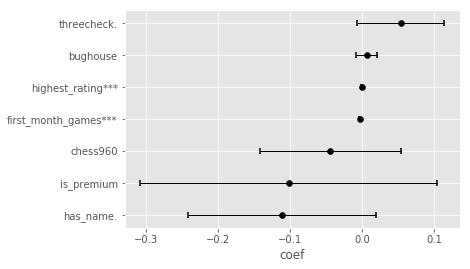

In [104]:
cph.plot();

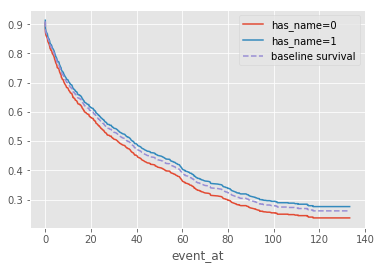

In [98]:
cph.plot_covariate_groups('has_name', [0, 1]);

AttributeError: module 'matplotlib.pyplot' has no attribute 'figsize'

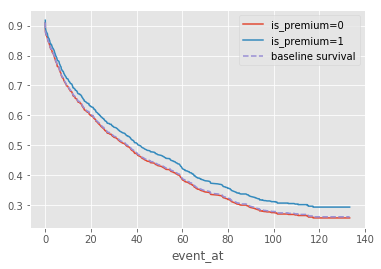

In [106]:
cph.plot_covariate_groups('is_premium', [0, 1]);

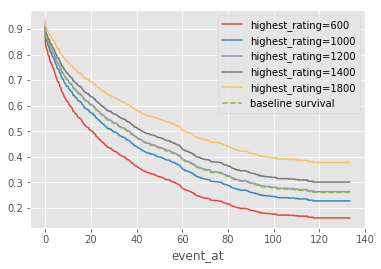

In [99]:
cph.plot_covariate_groups('highest_rating', [600, 1000, 1200, 1400, 1800]);

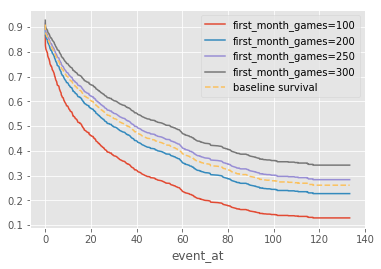

In [102]:
cph.plot_covariate_groups('first_month_games', [100, 200, 250, 300]);